## Imports

In [2]:
# Python standard library
import csv
import sys

# Scientific computing
import numpy as np
import scipy
import scipy.interpolate

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Pore stats
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi')
import optical_imaging as oi
import oi_file

## Load calculations

In [4]:
calculations_base_path = oi_file.ellipse_base_path

num_files = 2
dates = ['10-10-2017']*num_files
particles = ['293-T_0']*num_files
channels = ['10-20-10_1', '10-20-10_3']
indices = ['0']*num_files


calculations_file_paths = [calculations_base_path + dates[i] + '/' + particles[i] + '/' + channels[i] + '/' + indices[i] + '/' + 'calculations' for i in range(num_files)]


# Get header
with open(calculations_file_paths[0], 'r') as file_handle:
    file_reader = csv.reader(file_handle, delimiter = ',')
    header = file_reader.next()
    
header_dict = {header[i]:i for i in range(len(header))}
    
    
# Open calculations
calculationss = []
for i in range(num_files):
    calculations = np.genfromtxt(calculations_file_paths[i], delimiter = ',', skip_header = 1)    
    calculationss.append(calculations)
    
# Get number of events in each file
num_events = []
for i in range(num_files):
    num_events.append(int(np.max(calculationss[i][:,0])))

In [7]:
print header_dict
save = False

{'ellipse_num': 1, 'speed_pix/frame': 17, 'r_um': 14, 'xc_um': 5, 'r_pix': 13, 'yc_um': 8, 'a_um': 10, 'yc_pix': 7, 'speed_m/s': 18, 'tf': 2, 'a_pix': 9, 'b_um': 12, 'b_pix': 11, 'event_num': 0, 'y_pix': 6, 'xc_pix': 4, 'theta_rad': 16, 'aspect-ratio': 15, 'x_pix': 3}


In [6]:
def generate_file_path(file_index):
    return dates[file_index] + '/' + particles[file_index] + '/' + channels[file_index] + '/' + indices[file_index] + '/'

def get_event_calculations(calculations, event_index):
    event_calculations = np.copy(calculations[calculations[:,header_dict['event_num']] == event_index])
    return event_calculations

def get_event_column(calculations, event_index, column_index):
    return np.copy(calculations[calculations[:,header_dict['event_num']] == event_index][:,column_index])

## Size histogram

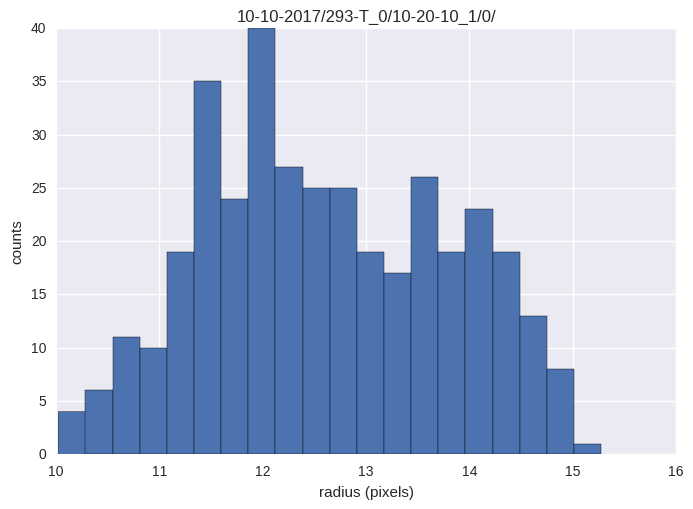

In [16]:
file_index = 0

calculations = calculationss[file_index]


avg_radii = []
xc_left = 50
xc_right = 100
for i in range(num_events[file_index]):
    event_calculations = get_event_calculations(calculations, i)
    
    xc_column = header_dict['xc_um']
    radius_column = header_dict['r_pix']
    
    xcs = get_event_column(calculations, i, xc_column)
    radii = get_event_column(calculations, i, radius_column)
    
    avg_radii.append(np.nanmean(radii[(xcs >= xc_left) & (xcs <= xc_right)]))


    
plt.hist(avg_radii, bins = 20)
plt.title(generate_file_path(file_index))
plt.xlabel('radius (pixels)')
plt.ylabel('counts')

if save:
    plt.savefig(oi_file.ellipse_base_path + generate_file_path(file_index) + 'sizes.png')

plt.show()

## Velocity plot

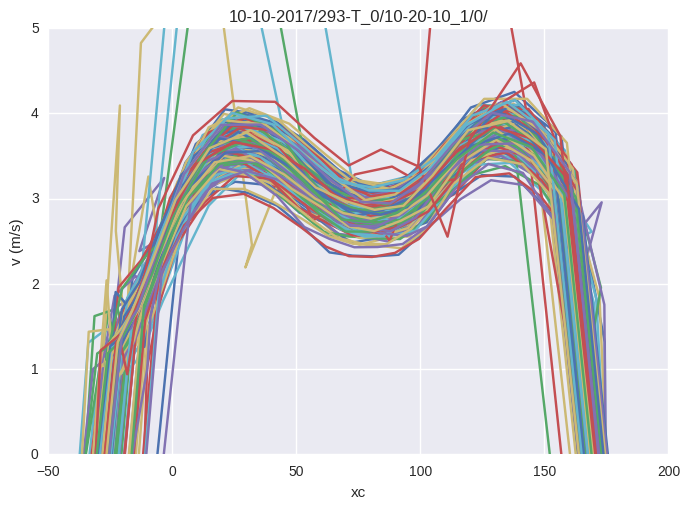

In [18]:
# Raw data
file_index = 0

calculations = calculationss[file_index]
xc_umss = calculations[:, header_dict['xc_um']]
velocitiess = calculations[:, header_dict['speed_m/s']]


for i in range(num_events[file_index]):
    xc_ums = xc_umss[calculations[:,0] == i]
    velocities = np.array(velocitiess[calculations[:,0] == i])/10**6.
    
    plt.plot(xc_ums, velocities)
    

plt.title(generate_file_path(file_index))
plt.xlabel('xc')
plt.ylabel('v (m/s)')

plt.ylim(0, 5)
    
plt.savefig(oi_file.ellipse_base_path + generate_file_path(file_index) + 'velocities.png')
    
plt.show()

## Aspect plot

##### Raw data

In [8]:
# Raw data
file_index = 0

calculations = calculationss[file_index]
xc_umss = calculations[:, header_dict['xc_um']]
aspectss = calculations[:, header_dict['aspect-ratio']]

# Avg.
avg_width = 3
num_avgs = (np.max(xc_umss) - np.min(xc_umss)) / avg_width
print num_avgs
xc_windows = []
aspect_avgs = []
aspect_stds = []
for i in range(int(num_avgs) + 1):
    low = np.min(xc_umss) + i*avg_width
    high = low + avg_width
    
    xc_windows.append((low + high)/2.)
    aspect_avgs.append(np.nanmean(aspectss[(xc_umss > low) & (xc_umss < high)]))
    aspect_stds.append(np.nanstd(aspectss[(xc_umss > low) & (xc_umss < high)]))
    
aspect_avgs = np.array(aspect_avgs)
aspect_stds = np.array(aspect_stds)

70.9842378811


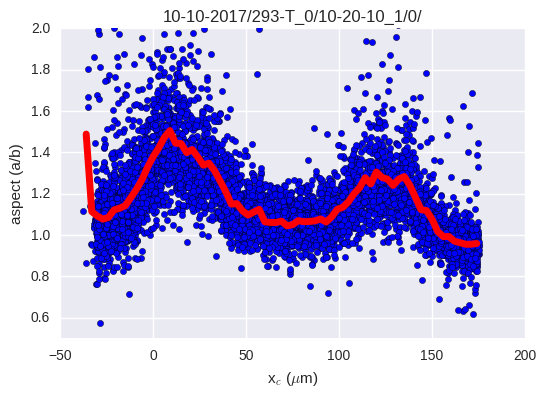

In [9]:
plt.scatter(xc_umss, aspectss)
plt.plot(xc_windows, aspect_avgs, zorder = 3, color = 'red', lw = 5)


plt.ylim(0.5, 2.0)

plt.title(generate_file_path(file_index))

plt.xlabel('x$_{c}$ ($\mu$m)')
plt.ylabel('aspect (a/b)')

if save:
    plt.savefig(oi_file.ellipse_base_path + generate_file_path(file_index) + 'aspects.png')


plt.show()

## Aspect-size scatter

In [14]:
avg_radius_pixss = []
avg_radius_umss = []

outside_aspectss = []
narrow_aspectss = []
cavity_aspectss = []

for i in range(num_files):
    
    avg_radius_pixs = []
    avg_radius_ums = []
    
    outside_aspects = []
    narrow_aspects = []
    cavity_aspects = []
    
    calculations = np.copy(calculationss[i])

    
    
    for j in range(num_events[i]):

        event_calculations = np.copy(calculations[calculations[:,header_dict['event_num']] == j])



        xc_ums = np.copy(event_calculations[:,header_dict['xc_um']])
        aspects = np.copy(event_calculations[:,header_dict['aspect-ratio']])
        radii_pix = np.copy(event_calculations[:,header_dict['r_pix']])
        radii_um = np.copy(event_calculations[:,header_dict['r_um']])


        avg_radius_pix = np.nanmean(radii_pix[(xc_ums > 50) & (xc_ums < 100)])
        avg_radius_um = np.nanmean(radii_um[(xc_ums > 50) & (xc_ums < 100)])
        
        outside_aspect = np.nanmean(aspects[(xc_ums > -50) & (xc_ums < 0)])
        narrow_aspect = np.nanmean(aspects[(xc_ums > 0) & (xc_ums < 50)])
        cavity_aspect = np.nanmean(aspects[(xc_ums > 50) & (xc_ums < 100)])


        avg_radius_pixs.append(avg_radius_pix)
        avg_radius_ums.append(avg_radius_um)
        outside_aspects.append(outside_aspect)
        narrow_aspects.append(narrow_aspect)
        cavity_aspects.append(cavity_aspect)



        
    avg_radius_pixss.append(avg_radius_pixs)
    avg_radius_umss.append(avg_radius_ums)
    
    outside_aspectss.append(outside_aspects)
    narrow_aspectss.append(narrow_aspects)
    cavity_aspectss.append(cavity_aspects)

In [15]:
for i in range(num_files):
    avg_radius_pixss[i] = np.array(avg_radius_pixss[i])
            
    avg_radius_umss[i] = np.array(avg_radius_umss[i])
    
    outside_aspectss[i] = np.array(outside_aspectss[i])
    narrow_aspectss[i] = np.array(narrow_aspectss[i])
    cavity_aspectss[i] = np.array(cavity_aspectss[i])
    
    
    
    # Remove nans
    keep_indices = ~(np.isnan(avg_radius_pixss[i])) * ~(np.isnan(outside_aspectss[i])) * ~(np.isnan(narrow_aspectss[i])) * ~(np.isnan(cavity_aspectss[i]))
    
    avg_radius_pixss[i] = avg_radius_pixss[i][keep_indices]
    avg_radius_umss[i] = avg_radius_umss[i][keep_indices]
    
    outside_aspectss[i] = outside_aspectss[i][keep_indices]
    narrow_aspectss[i] = narrow_aspectss[i][keep_indices]
    cavity_aspectss[i] = cavity_aspectss[i][keep_indices]
    

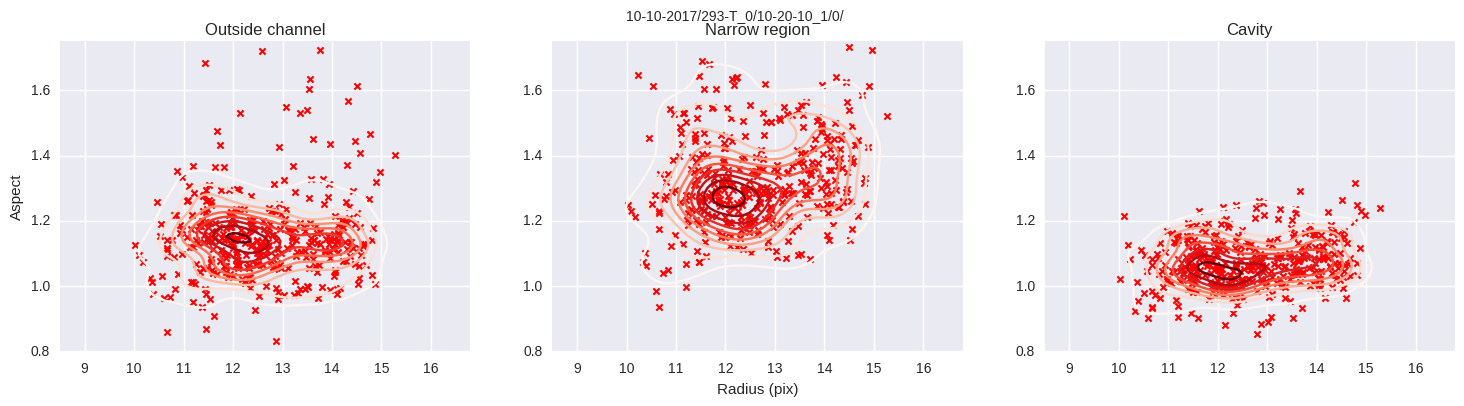

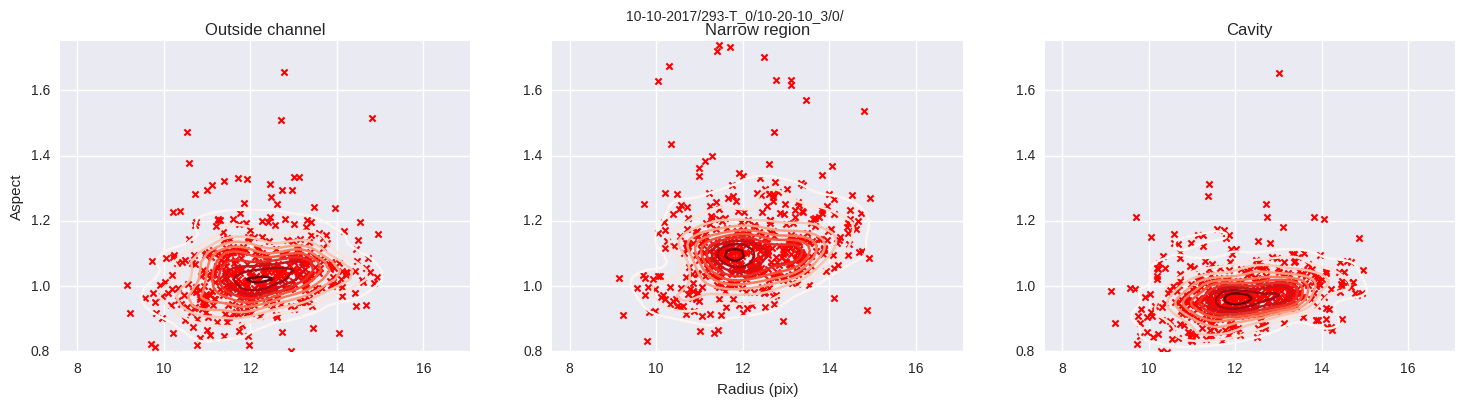

In [17]:
for i in range(num_files):    
    fig, axes = plt.subplots(1,3,figsize = (18,4))
    
    marker = 'x'
    color = 'red'
    # Outside
    fig.sca(axes[0])
    plt.scatter(avg_radius_pixss[i], outside_aspectss[i], marker = marker, color = color, lw = 1.5)
    sns.kdeplot(avg_radius_pixss[i], outside_aspectss[i], cmap = 'Reds')
    plt.ylim(0.8, 1.75)
    
    plt.title('Outside channel')
    plt.ylabel('Aspect')
    
    # Narrow
    fig.sca(axes[1])
    plt.scatter(avg_radius_pixss[i], narrow_aspectss[i], marker = marker, color = color, lw = 1.5)
    sns.kdeplot(avg_radius_pixss[i], narrow_aspectss[i], cmap = 'Reds')
    plt.ylim(0.8, 1.75)
    
    plt.title('Narrow region')
    plt.xlabel('Radius (pix)')
    
    
    # Cavity
    fig.sca(axes[2])
    plt.scatter(avg_radius_pixss[i], cavity_aspectss[i], marker = marker, color = color, lw = 1.5)
    sns.kdeplot(avg_radius_pixss[i], cavity_aspectss[i], cmap = 'Reds')
    plt.ylim(0.8, 1.75)
    
    plt.suptitle(generate_file_path(i))
    plt.title('Cavity')
    
    if save:
        plt.savefig(oi_file.ellipse_base_path + generate_file_path(i) + 'aspects.png')

    
    plt.show()

AttributeError: 'list' object has no attribute 'astype'

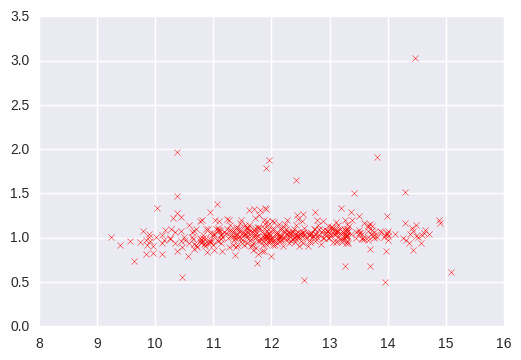

In [13]:
#plt.scatter(avg_radius_ums, narrow_aspects, marker = 'o', color = 'blue')
#sns.kdeplot(avg_radius_ums, narrow_aspects, cmap = 'Blues')

plt.scatter(avg_radius_pixs, outside_aspects, marker = 'x', color = 'red')
sns.kdeplot(avg_radius_pixs, outside_aspects, cmap = 'Reds')

#plt.scatter(avg_radius_pixs, cavity_aspects, marker = 'x', color = 'red')
#sns.kdeplot(avg_radius_pixs, cavity_aspects, cmap = 'Reds')

plt.show()